### Libraries

In [1]:
import tensorflow as tf 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 


### Import the dataset from the smaple data in tensorflow

In [2]:
from tensorflow import keras
(x_train_full, y_train_full), (x_test_orig, y_test_orig) = tf.keras.datasets.mnist.load_data()

# Combine original train and test sets
x_all = np.concatenate((x_train_full, x_test_orig), axis=0)
y_all = np.concatenate((y_train_full, y_test_orig), axis=0)

# Normalize
x_all = x_all / 255.0

# Shuffle before splitting
np.random.seed(42)  # for reproducibility
indices = np.random.permutation(len(x_all))

# 80/20 split
split_index = int(0.8 * len(x_all))
train_idx, test_idx = indices[:split_index], indices[split_index:]

x_train, y_train = x_all[train_idx], y_all[train_idx]
x_test, y_test = x_all[test_idx], y_all[test_idx]

print(f"Train set: {x_train.shape}, Test set: {x_test.shape}")

Train set: (56000, 28, 28), Test set: (14000, 28, 28)


We use train 80% and test 20% of the data. We use the train data to train the model and the test data

In [3]:
x_train.shape

(56000, 28, 28)

In [4]:
y_train.shape

(56000,)

In [5]:
x_test.shape

(14000, 28, 28)

In [6]:
test_size = len(y_train)/(len(y_test)+ len(y_train))
print(f"train size: {test_size}")

train size: 0.8


### Data overview 

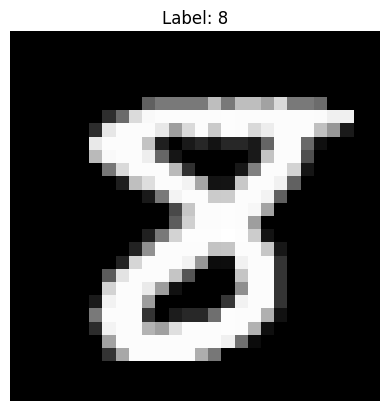

In [7]:
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()

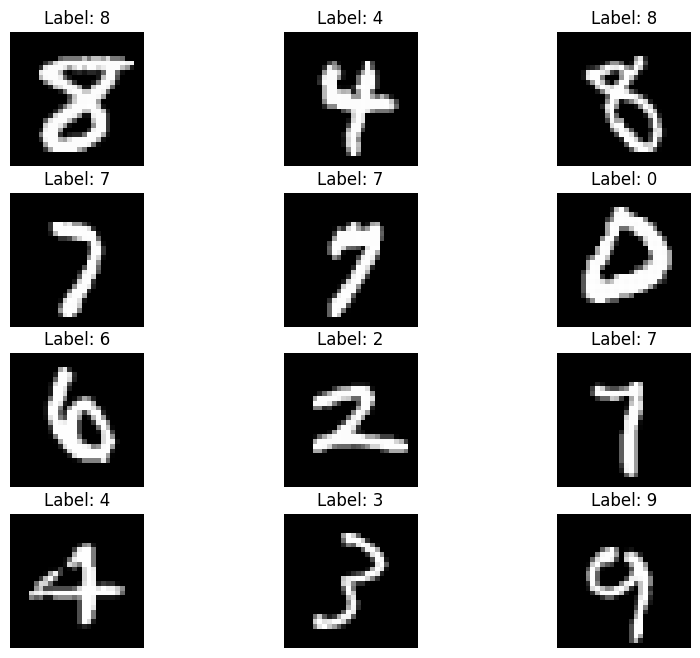

In [8]:
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(4, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

In [9]:
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

Number of classes: 10


### Buidld model 

In the step I want to use the relu for the activate function and I use hidden 1 have 128 and hidden 2 have 64 neurons

In [10]:
input_size = 28*28
hidden1 = 128
hidden2 = 64
output = 10

Initialize the weight and bias

In [11]:
initializer = tf.keras.initializers.GlorotUniform()

w1 = tf.Variable(initializer([input_size, hidden1]))
b1 = tf.Variable(tf.zeros([hidden1]))

w2 = tf.Variable(initializer([hidden1, hidden2]))
b2 = tf.Variable(tf.zeros([hidden2]))

w3 = tf.Variable(initializer([hidden2, num_classes]))
b3 = tf.Variable(tf.zeros([num_classes]))


Model, using Relu is the activate function

In [12]:
def model(x):
    x = tf.cast(x, tf.float32)
    x = tf.reshape(x, [x.shape[0], -1])
    
    z1 = tf.matmul(x, w1) + b1
    a1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(a1, w2)+ b2
    a2 = tf.nn.relu(z2)
    
    
    z3 = tf.matmul(a2, w3) + b3
    output = tf.nn.softmax(z3)
    return output
    

In [13]:

def cross_entropy_loss(y_true, y_pred):
    # Clip predictions to avoid log(0)
    y_pred = tf.clip_by_value(y_pred, 1e-10, 1.0)
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))


Model training

In [14]:
epochs = 10
lr = 0.01
batch_size = 64
optimizer = tf.optimizers.SGD(learning_rate=lr)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)

# Training loop with loss display
for epoch in range(epochs):
    epoch_loss = 0.0
    batch_count = 0

    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            preds = model(x_batch)
            loss = loss_fn(y_batch, preds)

        grads = tape.gradient(loss, [w1, b1, w2, b2, w3, b3])
        optimizer.apply_gradients(zip(grads, [w1, b1, w2, b2, w3, b3]))

        epoch_loss += loss.numpy()
        batch_count += 1

    avg_loss = epoch_loss / batch_count
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.9404
Epoch 2, Loss: 0.3799
Epoch 3, Loss: 0.3144
Epoch 4, Loss: 0.2800
Epoch 5, Loss: 0.2557
Epoch 6, Loss: 0.2363
Epoch 7, Loss: 0.2200
Epoch 8, Loss: 0.2056
Epoch 9, Loss: 0.1931
Epoch 10, Loss: 0.1819


In [15]:
predict = model(x_test)

In [16]:

# Make predictions
predict = model(x_test)

# Convert predictions and true labels to class indices
predicted_classes = tf.argmax(predict, axis=1)
true_classes = y_test # Use original labels directly

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(predicted_classes == true_classes, tf.float32))
print(f"Accuracy: {accuracy.numpy() * 100:.2f}%")

Accuracy: 94.60%


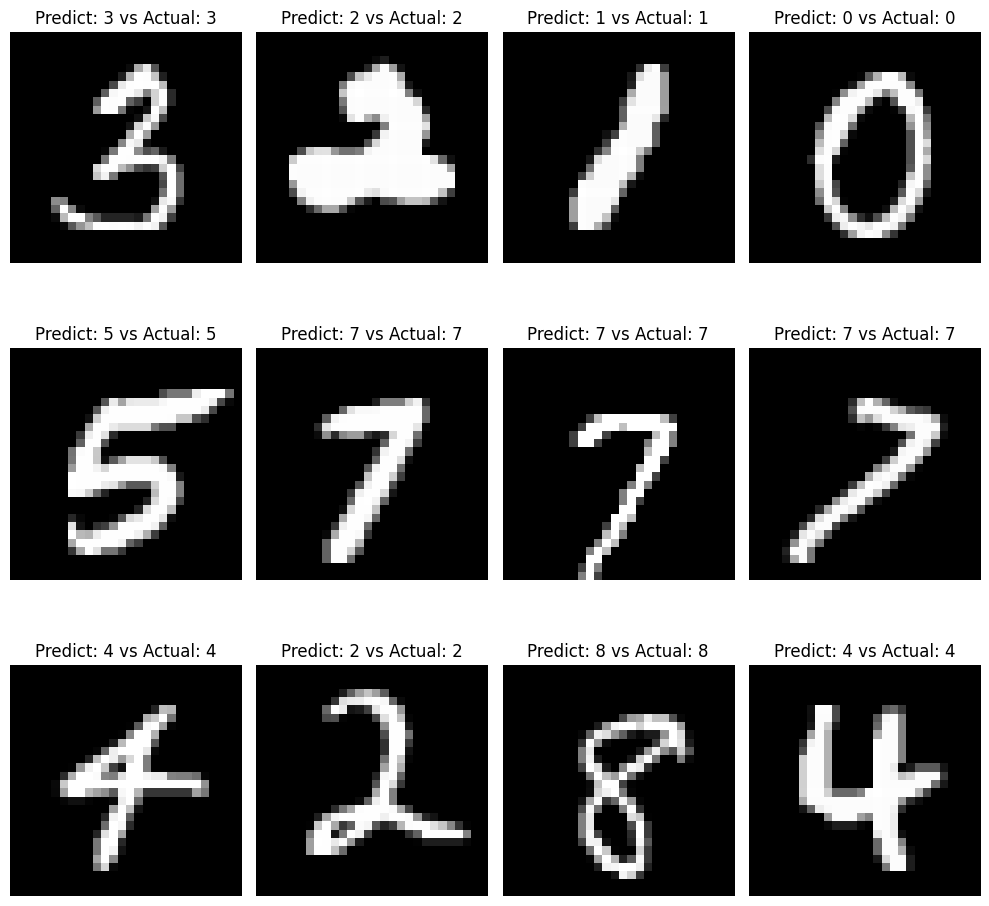

In [17]:
plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Predict: {predicted_classes[i]} vs Actual: {y_test[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

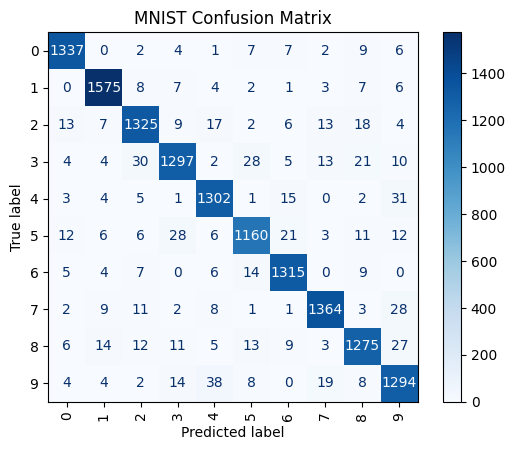

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make sure test data is flattened to [batch_size, 784]
x_test_flat = x_test.reshape([-1, 784]).astype(np.float32)

# Get predictions from the model
logits = model(x_test_flat)
predict = tf.argmax(logits, axis=1).numpy()  # Get predicted class indices

# Compute confusion matrix
cm = confusion_matrix(y_test, predict)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("MNIST Confusion Matrix")
plt.show()


In [19]:
from sklearn.metrics import classification_report
report = classification_report(y_test, predict, digits=4)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0     0.9654    0.9753    0.9703      1375
           1     0.9657    0.9789    0.9723      1613
           2     0.9528    0.9286    0.9405      1414
           3     0.9248    0.9399    0.9323      1414
           4     0.9430    0.9582    0.9505      1364
           5     0.9614    0.9067    0.9333      1265
           6     0.9557    0.9684    0.9620      1360
           7     0.9504    0.9650    0.9576      1429
           8     0.9256    0.9316    0.9286      1375
           9     0.9350    0.9202    0.9275      1391

    accuracy                         0.9481     14000
   macro avg     0.9480    0.9473    0.9475     14000
weighted avg     0.9481    0.9481    0.9480     14000



### For 128 layers
In this step I want to test the number of neuron with 128 for both hidden layers 1 and 2 


In [23]:
input_size = 28*28
hidden1 = 128
hidden2 = 128
output = 10

In [24]:
initializer = tf.keras.initializers.GlorotUniform()

w1 = tf.Variable(initializer([input_size, hidden1]))
b1 = tf.Variable(tf.zeros([hidden1]))

w2 = tf.Variable(initializer([hidden1, hidden2]))
b2 = tf.Variable(tf.zeros([hidden2]))

w3 = tf.Variable(initializer([hidden2, num_classes]))
b3 = tf.Variable(tf.zeros([num_classes]))


In [25]:
def model(x):
    x = tf.cast(x, tf.float32)
    x = tf.reshape(x, [x.shape[0], -1])
    
    z1 = tf.matmul(x, w1) + b1
    a1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(a1, w2)+ b2
    a2 = tf.nn.relu(z2)
    
    
    z3 = tf.matmul(a2, w3) + b3
    output = tf.nn.softmax(z3)
    return output
    

In [26]:
epochs = 10
lr = 0.01
batch_size = 64
optimizer = tf.optimizers.SGD(learning_rate=lr)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)

# Training loop with loss display
for epoch in range(epochs):
    epoch_loss = 0.0
    batch_count = 0

    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            preds = model(x_batch)
            loss = loss_fn(y_batch, preds)

        grads = tape.gradient(loss, [w1, b1, w2, b2, w3, b3])
        optimizer.apply_gradients(zip(grads, [w1, b1, w2, b2, w3, b3]))

        epoch_loss += loss.numpy()
        batch_count += 1

    avg_loss = epoch_loss / batch_count
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.9090
Epoch 2, Loss: 0.3818
Epoch 3, Loss: 0.3162
Epoch 4, Loss: 0.2825
Epoch 5, Loss: 0.2590
Epoch 6, Loss: 0.2403
Epoch 7, Loss: 0.2244
Epoch 8, Loss: 0.2105
Epoch 9, Loss: 0.1987
Epoch 10, Loss: 0.1877


In [ ]:
y_pred = model(x_test)
y_pred = tf.argmax(y_pred, axis=1).numpy() 


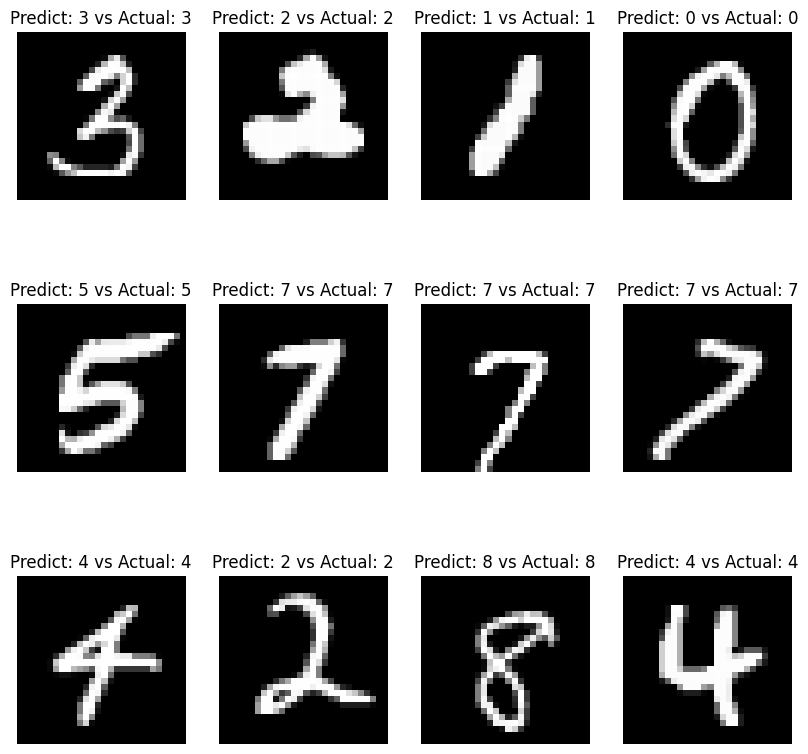

In [30]:
plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Predict: {y_pred[i]} vs Actual: {y_test[i]}")
    plt.axis('off')

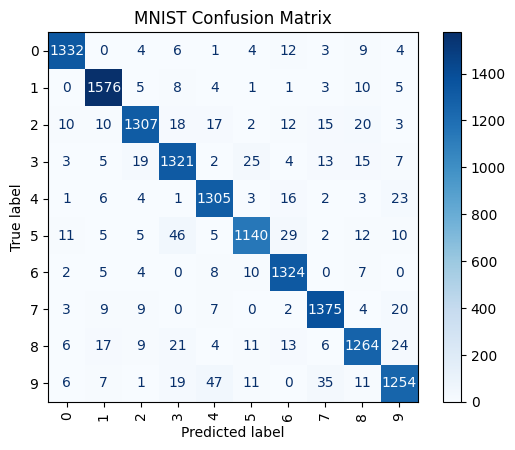

Classification Report:

              precision    recall  f1-score   support

           0     0.9694    0.9687    0.9691      1375
           1     0.9610    0.9771    0.9690      1613
           2     0.9561    0.9243    0.9399      1414
           3     0.9174    0.9342    0.9257      1414
           4     0.9321    0.9567    0.9443      1364
           5     0.9445    0.9012    0.9223      1265
           6     0.9370    0.9735    0.9549      1360
           7     0.9457    0.9622    0.9539      1429
           8     0.9328    0.9193    0.9260      1375
           9     0.9289    0.9015    0.9150      1391

    accuracy                         0.9427     14000
   macro avg     0.9425    0.9419    0.9420     14000
weighted avg     0.9428    0.9427    0.9426     14000



In [37]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("MNIST Confusion Matrix")
plt.show()
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n")
print(report)